In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import zipfile
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import random
from itertools import product

In [5]:
# Config
DATA_DIR = "Img.zip"
IMG_SIZE = (28,28)
RANDOM_SEED = 42
NUM_CLASSES = 62

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [6]:
with zipfile.ZipFile("/content/Img.zip", 'r') as zf:
    zf.extractall("/content/images")

df = pd.read_csv("/content/english.csv")

def load_images_from_csv(csv_df, base_dir="/content/images", img_size=(28,28)):
    X, y = [], []
    for _, row in csv_df.iterrows():
        rel_path = row["image"]
        full_path = os.path.join(base_dir, rel_path)
        if os.path.exists(full_path):
            img = Image.open(full_path).convert("L").resize(img_size)
            arr = np.array(img, dtype=np.float32) / 255.0
            X.append(arr.flatten())
            y.append(row["label"])
        else:
            print("Missing file:", full_path)
    return np.array(X), np.array(y)

X, y_raw = load_images_from_csv(df, "/content/images", IMG_SIZE)
print("Dataset:", X.shape, "Unique labels:", len(set(y_raw)))

# Encode labels & split
le = LabelEncoder()
y = le.fit_transform(y_raw)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_SEED
)

# Normalize
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)



Dataset: (3410, 784) Unique labels: 62


In [7]:
# PLA (One-vs-Rest Perceptron from scratch)
class PerceptronOVR:
    def __init__(self, input_dim, num_classes, eta=0.01, max_epochs=10):
        self.W = np.zeros((num_classes, input_dim+1))
        self.eta = eta
        self.max_epochs = max_epochs
        self.num_classes = num_classes

    def _bias(self, X):
        return np.hstack([np.ones((X.shape[0],1)), X])

    def fit(self, X, y):
        Xb = self._bias(X)
        for epoch in range(self.max_epochs):
            errors = 0
            for i in range(Xb.shape[0]):
                xi, yi = Xb[i], y[i]
                pred = np.argmax(self.W @ xi)
                if pred != yi:
                    self.W[yi] += self.eta * xi
                    self.W[pred] -= self.eta * xi
                    errors += 1
            print(f"Epoch {epoch+1}, errors={errors}")

    def predict(self, X):
        return np.argmax(self.W @ self._bias(X).T, axis=0)

pla = PerceptronOVR(input_dim=X_train_s.shape[1], num_classes=NUM_CLASSES, eta=0.01, max_epochs=10)
pla.fit(X_train_s, y_train)
y_pred_pla = pla.predict(X_test_s)
print(classification_report(y_test, y_pred_pla))


Epoch 1, errors=2041
Epoch 2, errors=1717
Epoch 3, errors=1529
Epoch 4, errors=1399
Epoch 5, errors=1290
Epoch 6, errors=1231
Epoch 7, errors=1133
Epoch 8, errors=1110
Epoch 9, errors=1095
Epoch 10, errors=955
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         8
           2       0.27      0.38      0.32         8
           3       0.33      0.25      0.29         8
           4       0.20      0.12      0.15         8
           5       0.17      0.12      0.14         8
           6       0.22      0.25      0.24         8
           7       0.50      0.33      0.40         9
           8       0.00      0.00      0.00         8
           9       0.27      0.38      0.32         8
          10       0.45      0.62      0.53         8
          11       0.17      0.22      0.19         9
          12       0.44      0.50      0.47         8
          13       0.10      0.12

In [8]:
# MLP Model (PyTorch)
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, num_classes, activation='relu', dropout=0.0):
        super().__init__()
        layers, prev = [], input_dim
        act_map = {'relu':nn.ReLU, 'tanh':nn.Tanh, 'sigmoid':nn.Sigmoid}
        for h in hidden_layers:
            layers += [nn.Linear(prev, h), act_map[activation]()]
            if dropout>0: layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, num_classes))
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)


In [9]:
# Training Utilities
def make_loader(X, y, batch=64, shuffle=True):
    ds = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
    return DataLoader(ds, batch_size=batch, shuffle=shuffle)

def train_epoch(model, loader, opt, device):
    model.train(); total=0
    for xb,yb in loader:
        xb,yb = xb.to(device), yb.to(device)
        out = model(xb)
        loss = F.cross_entropy(out, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item()*xb.size(0)
    return total/len(loader.dataset)

def eval_model(model, loader, device):
    model.eval(); preds, labs = [], []
    total=0
    with torch.no_grad():
        for xb,yb in loader:
            xb,yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = F.cross_entropy(out, yb)
            total += loss.item()*xb.size(0)
            preds.append(out.argmax(1).cpu().numpy())
            labs.append(yb.cpu().numpy())
    return total/len(loader.dataset), np.concatenate(preds), np.concatenate(labs)

# Hyperparameter grid
hyperparams = {
    'hidden_layers': [[128], [256], [256,128], [512,256]],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'dropout': [0.0, 0.2, 0.5],
    'lr': [1e-2, 1e-3, 1e-4],
    'batch_size': [64, 128, 256]
}

# Train MLP
device = "cuda" if torch.cuda.is_available() else "cpu"

best_val_acc = 0
best_config = None
best_model_state = None

# Iterate over all hyperparameter combinations
for hl, act, do, lr, bs in product(
    hyperparams['hidden_layers'],
    hyperparams['activation'],
    hyperparams['dropout'],
    hyperparams['lr'],
    hyperparams['batch_size']
):
    # Prepare loaders with current batch size
    train_loader = make_loader(X_train_s, y_train, batch=bs)
    val_loader = make_loader(X_val_s, y_val, batch=bs, shuffle=False)

    # Initialize model and optimizer
    model = MLP(X_train_s.shape[1], hl, NUM_CLASSES, activation=act, dropout=do).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)

    # Train for a few epochs (e.g., 5 for tuning speed)
    for epoch in range(5):
        train_epoch(model, train_loader, opt, device)

    # Evaluate on validation set
    _, y_val_pred, y_val_true = eval_model(model, val_loader, device)
    val_acc = (y_val_pred == y_val_true).mean()

    print(f"Config: HL={hl}, act={act}, dropout={do}, lr={lr}, batch={bs} => val_acc={val_acc:.3f}")

    # Save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_config = {'hidden_layers': hl, 'activation': act, 'dropout': do, 'lr': lr, 'batch_size': bs}
        best_model_state = model.state_dict()

print("Best hyperparameters:", best_config, "Validation Accuracy:", best_val_acc)

train_loader = make_loader(X_train_s, y_train, batch=best_config['batch_size'])
val_loader = make_loader(X_val_s, y_val, batch=best_config['batch_size'], shuffle=False)
test_loader = make_loader(X_test_s, y_test, batch=best_config['batch_size'], shuffle=False)

model = MLP(X_train_s.shape[1], best_config['hidden_layers'], NUM_CLASSES,
            activation=best_config['activation'], dropout=best_config['dropout']).to(device)
model.load_state_dict(best_model_state)  # Optionally start from tuned weights
opt = optim.Adam(model.parameters(), lr=best_config['lr'])

history = {'train_loss':[], 'val_loss':[], 'val_acc':[]}
for epoch in range(20):
    tl = train_epoch(model, train_loader, opt, device)
    vl, vp, vlabs = eval_model(model, val_loader, device)
    acc = (vp==vlabs).mean()
    history['train_loss'].append(tl); history['val_loss'].append(vl); history['val_acc'].append(acc)
    print(f"Epoch {epoch+1}: train={tl:.3f}, val={vl:.3f}, acc={acc:.3f}")

'''
device = "cuda" if torch.cuda.is_available() else "cpu"
train_loader = make_loader(X_train_s, y_train, batch=128)
val_loader = make_loader(X_val_s, y_val, batch=256)
test_loader = make_loader(X_test_s, y_test, batch=256)

model = MLP(X_train_s.shape[1], [256,128], NUM_CLASSES, activation='relu', dropout=0.2).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)

history = {'train_loss':[], 'val_loss':[], 'val_acc':[]}
for epoch in range(20):
    tl = train_epoch(model, train_loader, opt, device)
    vl, vp, vlabs = eval_model(model, val_loader, device)
    acc = (vp==vlabs).mean()
    history['train_loss'].append(tl); history['val_loss'].append(vl); history['val_acc'].append(acc)
    print(f"Epoch {epoch+1}: train={tl:.3f}, val={vl:.3f}, acc={acc:.3f}")
'''

Config: HL=[128], act=relu, dropout=0.0, lr=0.01, batch=64 => val_acc=0.456
Config: HL=[128], act=relu, dropout=0.0, lr=0.01, batch=128 => val_acc=0.423
Config: HL=[128], act=relu, dropout=0.0, lr=0.01, batch=256 => val_acc=0.397
Config: HL=[128], act=relu, dropout=0.0, lr=0.001, batch=64 => val_acc=0.384
Config: HL=[128], act=relu, dropout=0.0, lr=0.001, batch=128 => val_acc=0.329
Config: HL=[128], act=relu, dropout=0.0, lr=0.001, batch=256 => val_acc=0.276
Config: HL=[128], act=relu, dropout=0.0, lr=0.0001, batch=64 => val_acc=0.125
Config: HL=[128], act=relu, dropout=0.0, lr=0.0001, batch=128 => val_acc=0.082
Config: HL=[128], act=relu, dropout=0.0, lr=0.0001, batch=256 => val_acc=0.043
Config: HL=[128], act=relu, dropout=0.2, lr=0.01, batch=64 => val_acc=0.391
Config: HL=[128], act=relu, dropout=0.2, lr=0.01, batch=128 => val_acc=0.403
Config: HL=[128], act=relu, dropout=0.2, lr=0.01, batch=256 => val_acc=0.429
Config: HL=[128], act=relu, dropout=0.2, lr=0.001, batch=64 => val_acc=

'\ndevice = "cuda" if torch.cuda.is_available() else "cpu"\ntrain_loader = make_loader(X_train_s, y_train, batch=128)\nval_loader = make_loader(X_val_s, y_val, batch=256)\ntest_loader = make_loader(X_test_s, y_test, batch=256)\n\nmodel = MLP(X_train_s.shape[1], [256,128], NUM_CLASSES, activation=\'relu\', dropout=0.2).to(device)\nopt = optim.Adam(model.parameters(), lr=1e-3)\n\nhistory = {\'train_loss\':[], \'val_loss\':[], \'val_acc\':[]}\nfor epoch in range(20):\n    tl = train_epoch(model, train_loader, opt, device)\n    vl, vp, vlabs = eval_model(model, val_loader, device)\n    acc = (vp==vlabs).mean()\n    history[\'train_loss\'].append(tl); history[\'val_loss\'].append(vl); history[\'val_acc\'].append(acc)\n    print(f"Epoch {epoch+1}: train={tl:.3f}, val={vl:.3f}, acc={acc:.3f}")\n'

MLP Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.25      0.33         8
           1       0.40      0.50      0.44         8
           2       0.56      0.62      0.59         8
           3       0.67      0.75      0.71         8
           4       0.40      0.25      0.31         8
           5       0.17      0.12      0.14         8
           6       0.56      0.62      0.59         8
           7       0.55      0.67      0.60         9
           8       0.62      1.00      0.76         8
           9       0.60      0.75      0.67         8
          10       0.50      0.75      0.60         8
          11       0.56      0.56      0.56         9
          12       0.86      0.75      0.80         8
          13       0.50      0.25      0.33         8
          14       0.27      0.38      0.32         8
          15       0.50      0.62      0.56         8
          16       1.00      0.75      0.86         8

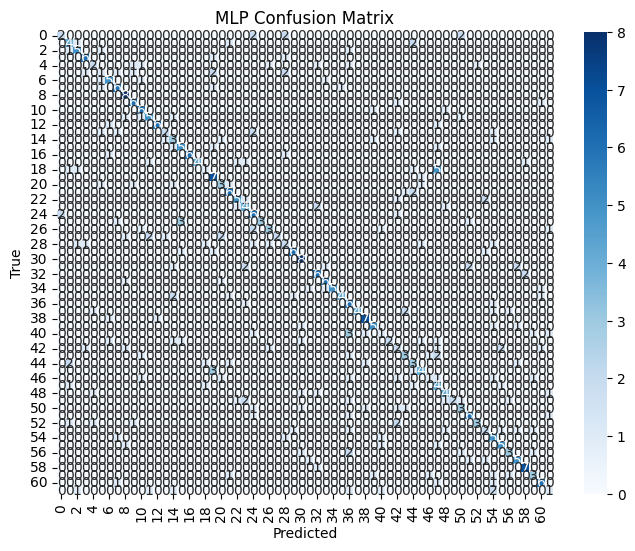

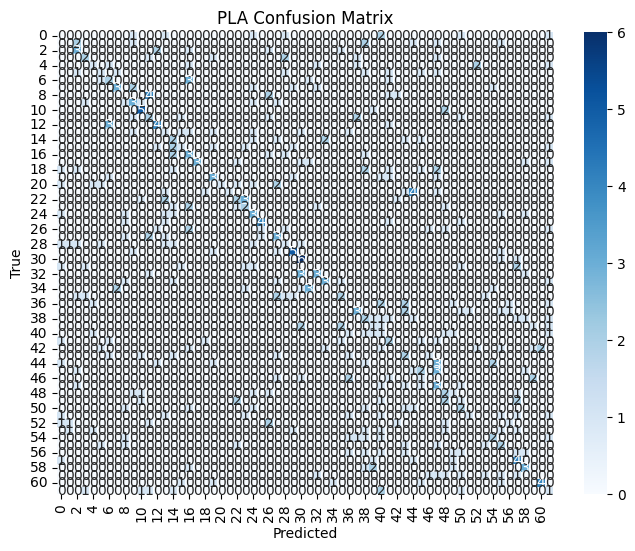

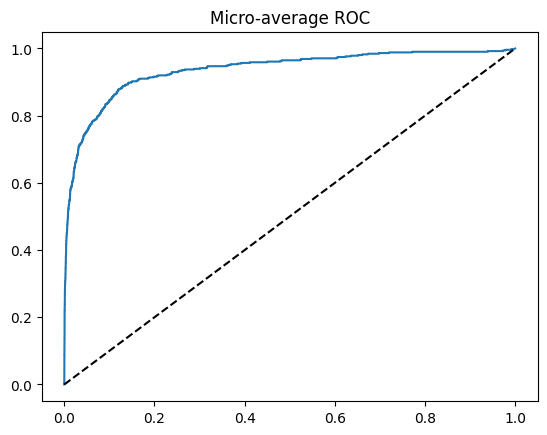

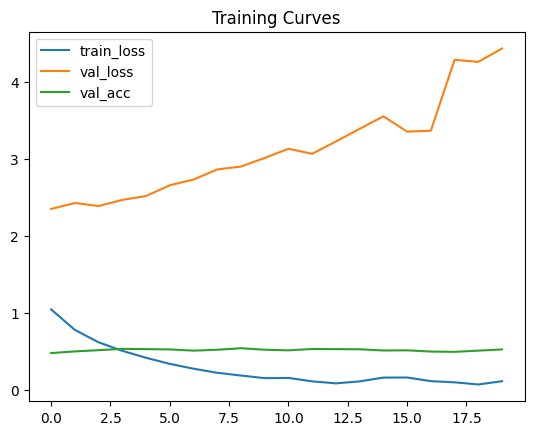

In [10]:
# Evaluation (MLP vs PLA)
# Test set
_, y_pred_mlp, _ = eval_model(model, test_loader, device)
print("MLP Classification Report:\n", classification_report(y_test, y_pred_mlp))
print("PLA Classification Report:\n", classification_report(y_test, y_pred_pla))

# Confusion Matrix Example (MLP)
cm = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Confusion Matrix Example (PLA)
cm = confusion_matrix(y_test, y_pred_pla)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("PLA Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC (micro-average)
def predict_proba(model, loader):
    model.eval(); out=[]
    with torch.no_grad():
        for xb,_ in loader:
            logits = model(xb.to(device))
            out.append(F.softmax(logits,1).cpu().numpy())
    return np.vstack(out)

probs = predict_proba(model, test_loader)
y_onehot = np.eye(NUM_CLASSES)[y_test]
fpr,tpr,_ = roc_curve(y_onehot.ravel(), probs.ravel())
plt.plot(fpr,tpr); plt.plot([0,1],[0,1],'k--')
plt.title("Micro-average ROC"); plt.show()

# Plot Training Curves
plt.plot(history['train_loss'], label="train_loss")
plt.plot(history['val_loss'], label="val_loss")
plt.plot(history['val_acc'], label="val_acc")
plt.legend(); plt.title("Training Curves"); plt.show()
